In [ ]:
!pip -q install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

matplotlib.rc('xtick', labelsize=15)

In [ ]:
train = pd.read_csv('/train.csv')
test = pd.read_csv('/test.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

train.columns = [c.lower() for c in train.columns.values]
test.columns = [c.lower() for c in test.columns.values]

Train shape: (381109, 12)
Test shape: (127037, 11)


In [ ]:
print(f'Does Train have any null values?: {train.isnull().sum().any()}')
print(f'Does Test have any null values?: {test.isnull().sum().any()}')

Does Train have any null values?: False
Does Test have any null values?: False


In [ ]:
train['train'] = 1
test['train'] = 0

unified = pd.concat([train, test], axis=0)
unified.shape

(508146, 13)

## EDA

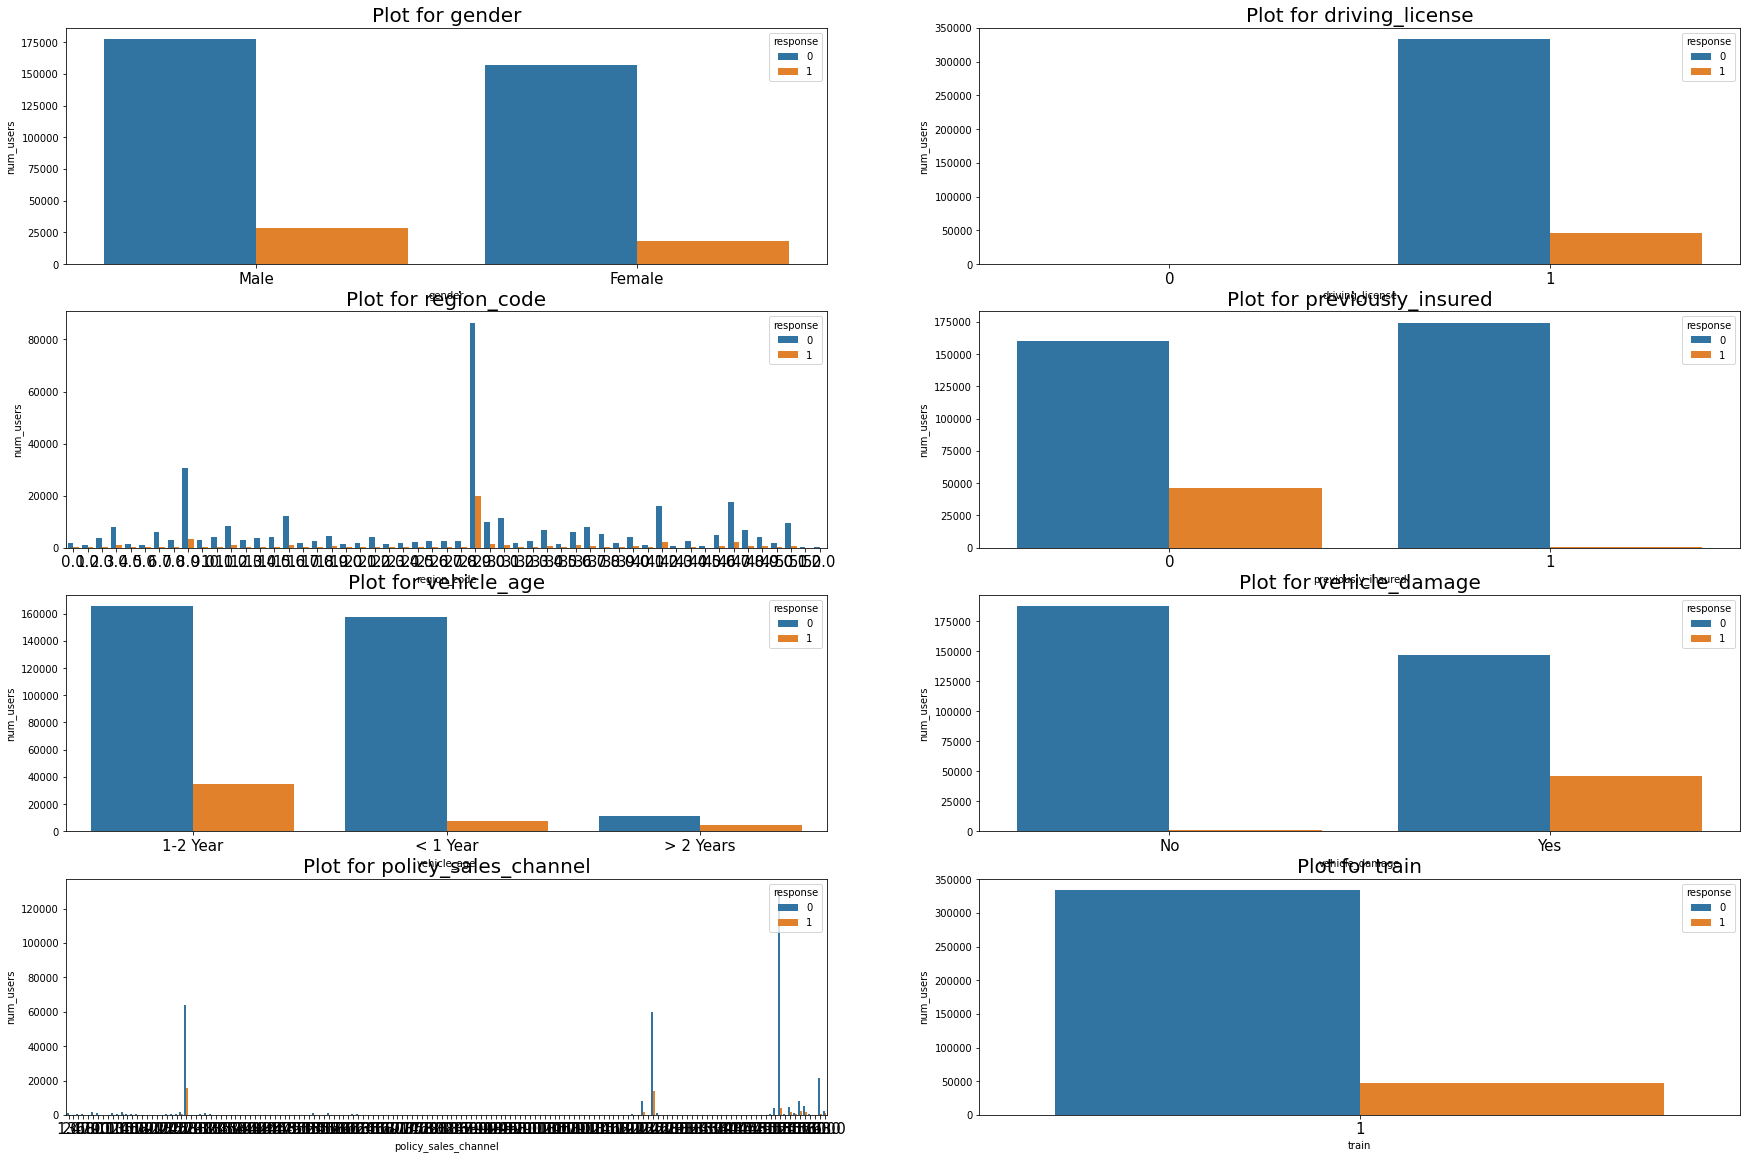

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(30,20))

cols = train.columns.values.tolist()
cols = [c for c in cols if c not in ('id', 'age', 'annual_premium',
                                     'vintage', 'response')]

for i in range(len(cols)):
  tmp = train.groupby([cols[i], 'response'])['id'].count().reset_index().\
                                rename(columns={'id':'num_users'}).\
                                sort_values(by='num_users', ascending=False)

  sns.barplot(x=tmp[cols[i]], y=tmp['num_users'], hue=tmp['response'], ax=ax[int(i/2)][i%2])
  ax[int(i/2)][i%2].set_title(f'Plot for {cols[i]}', fontsize=20)

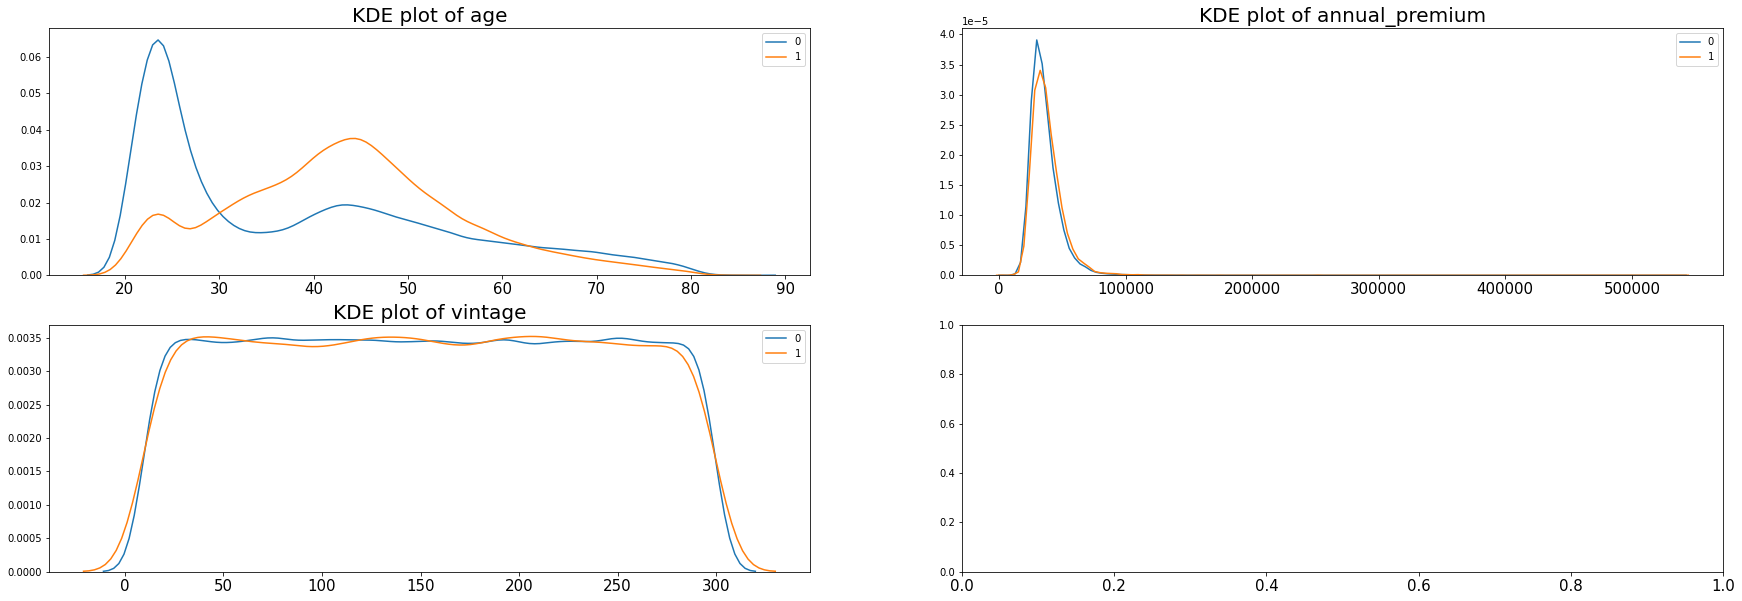

In [ ]:
cont_var = ['age', 'annual_premium', 'vintage']
fig, ax = plt.subplots(2,2, figsize=(30,10))

for i in range(len(cont_var)):
  sns.kdeplot(train.loc[train['response']==0, cont_var[i]], label='0',
              ax=ax[int(i/2)][i%2])
  sns.kdeplot(train.loc[train['response']==1, cont_var[i]], label='1',
              ax=ax[int(i/2)][i%2])

  ax[int(i/2)][i%2].set_title(f'KDE plot of {cont_var[i]}', fontsize=20)

> Findings of EDA graphs:

1. People who dont have car insurance are more likely to buy.
2. Car owners with vehicle age 1-2 years will most likely buy.
3. If customer damaged their vehicle in the past they are more likely to buy.
4. Age in band of 10 years show a distinct pattern between people who bought
insurance vs. those who didn't buy.

## Feature Engineering

### Binning Continuous Variables

In [ ]:
# def bin_continuous_vars(df, column, bin_start, bin_end, num_bins, label_list):
#   tmp = df.copy()
#   tmp[f'binned_{column}'] = pd.cut(x=tmp[column], bins=np.linspace(bin_start,
#                                                                    bin_end,
#                                                                    num=num_bins),
#                                    labels=label_list)
  
#   return tmp

In [ ]:
# ann_prem_label_list = ['0-5000', '5000-10000', '10000-15000', '15000-20000',
#                        '20000-25000', '25000-30000', '30000-35000', 
#                        '35000-40000', '40000-45000', '45000-50000',
#                        '50000-55000', '55000-60000', '60000-65000',
#                        '65000-70000', '70000-75000', '75000-80000',
#                        '80000-85000', '85000-90000', '90000-95000', 
#                        '95000-100000']

# age_label_list = ['10-20', '20-30', '30-40', '40-50', 
#                   '50-60', '60-70', '70-80', '80-90']                       

# vintage_label_list = ['0-60', '60-120', '120-180', '180-240', '240-300']

# unified = bin_continuous_vars(unified, 'annual_premium', 0, 100000, 21, 
#                             ann_prem_label_list)
# unified = bin_continuous_vars(unified, 'age', 10, 90, 9, 
#                             age_label_list)
# unified = bin_continuous_vars(unified, 'vintage', 0, 300, 6,
#                             vintage_label_list)

In [ ]:
# unified.head()

In [ ]:
# print(unified['binned_annual_premium'].isnull().sum().any())
# print(unified['binned_age'].isnull().sum().any())
# print(unified['binned_vintage'].isnull().sum().any())

In [ ]:
# unified['binned_annual_premium'] = unified['binned_annual_premium'].cat.add_categories('>100000')
# unified['binned_annual_premium'].fillna('>100000', inplace=True)

In [ ]:
# annual_premium_bins = {  '0-5000': 0
#                        , '5000-10000': 1
#                        , '10000-15000': 2
#                        , '15000-20000': 3
#                        , '20000-25000': 4
#                        , '25000-30000': 5
#                        , '30000-35000': 6
#                        , '35000-40000': 7
#                        , '40000-45000': 8
#                        , '45000-50000': 9
#                        , '50000-55000': 10
#                        , '55000-60000': 11
#                        , '60000-65000': 12
#                        , '65000-70000': 13
#                        , '70000-75000': 14
#                        , '75000-80000': 15
#                        , '80000-85000': 16
#                        , '85000-90000': 17
#                        , '90000-95000': 18
#                        , '95000-100000': 19
#                        , '>100000': 20
#                        }

# age_bins = {  '10-20': 0
#             , '20-30': 1
#             , '30-40': 2
#             , '40-50': 3
#             , '50-60': 4
#             , '60-70': 5
#             , '70-80': 6
#             , '80-90': 7
#             }                       

# vintage_bins = {  '0-60': 0
#                 , '60-120': 1
#                 , '120-180': 2
#                 , '180-240': 3
#                 , '240-300':4 
#                 }    

In [ ]:
# unified['annual_premium_bins'] = unified['binned_annual_premium'].map(annual_premium_bins)
# unified['age_bins'] = unified['binned_age'].map(age_bins)
# unified['vintage_bins'] = unified['binned_vintage'].map(vintage_bins)

In [ ]:
# fig, ax = plt.subplots(2,2, figsize=(30, 10))
# continuous_var_bins = ['annual_premium_bins', 'age_bins', 'vintage_bins']

# train = unified[unified['train']==1]

# for i in range(len(continuous_var_bins)):
#   sns.kdeplot(train.loc[train['response']==0, continuous_var_bins[i]], label='0',
#               ax=ax[int(i/2)][i%2])
#   sns.kdeplot(train.loc[train['response']==1, continuous_var_bins[i]], label='1',
#               ax=ax[int(i/2)][i%2])
#   ax[int(i/2)][i%2].set_title(f'{continuous_var_bins[i]} distribution', 
#                               fontsize=20)

### Binning Categorical Variables

In [ ]:
gender_bins = {  'Male': 0
               , 'Female': 1
               }

vehicle_age_bins = {  '< 1 Year': 0
                    , '1-2 Year': 1
                    , '> 2 Years': 2
                    }

vehicle_damage_bins = {  'No': 0
                       , 'Yes': 1
                      }

In [ ]:
unified['gender_bins'] = unified['gender'].map(gender_bins)
unified['vehicle_age_bins'] = unified['vehicle_age'].map(vehicle_age_bins)
unified['vehicle_damage_bins'] = unified['vehicle_damage'].map(vehicle_damage_bins)

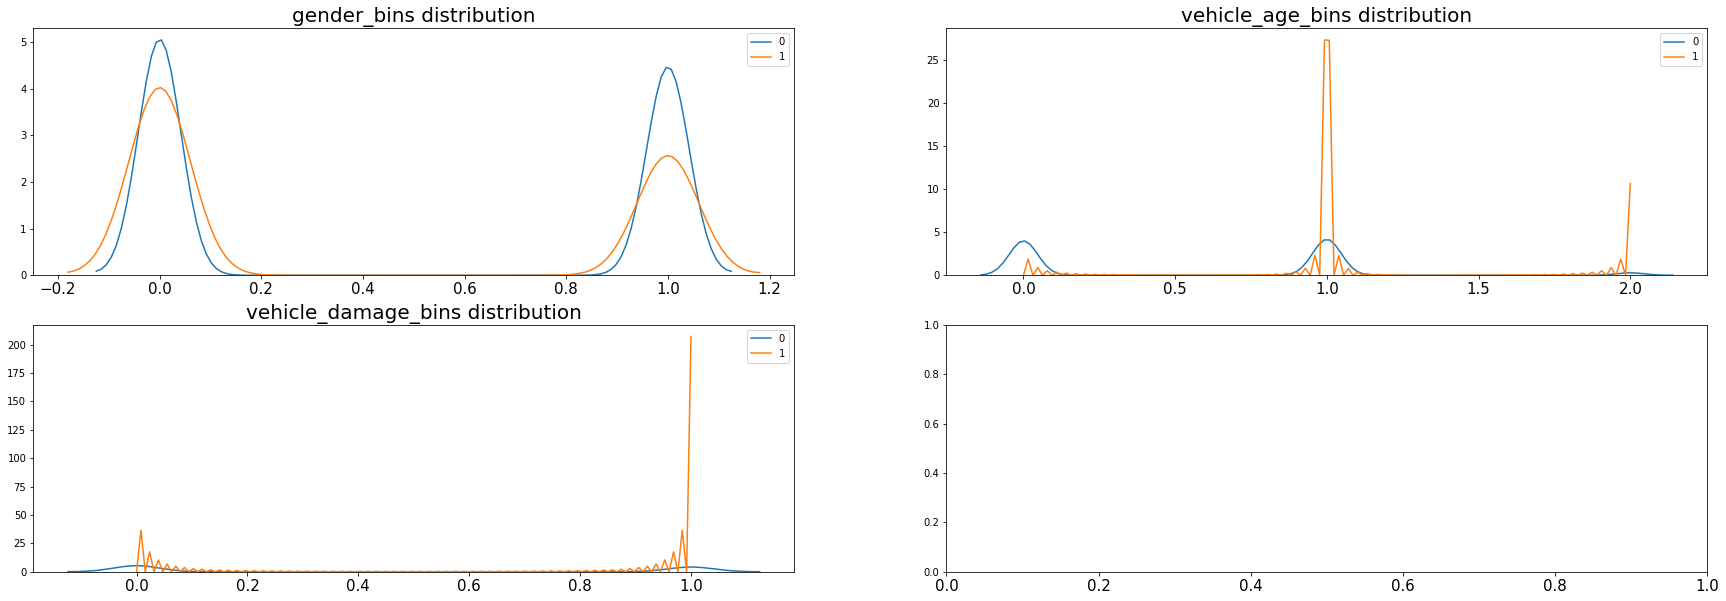

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(30, 10))
cat_var_bins = ['gender_bins', 'vehicle_age_bins', 'vehicle_damage_bins']

train = unified[unified['train']==1]

for i in range(len(cat_var_bins)):
  sns.kdeplot(train.loc[train['response']==0, cat_var_bins[i]], label='0',
              ax=ax[int(i/2)][i%2])
  sns.kdeplot(train.loc[train['response']==1, cat_var_bins[i]], label='1',
              ax=ax[int(i/2)][i%2])
  ax[int(i/2)][i%2].set_title(f'{cat_var_bins[i]} distribution', 
                              fontsize=20)

In [ ]:
unified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508146 entries, 0 to 127036
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    508146 non-null  int64  
 1   gender                508146 non-null  object 
 2   age                   508146 non-null  int64  
 3   driving_license       508146 non-null  int64  
 4   region_code           508146 non-null  float64
 5   previously_insured    508146 non-null  int64  
 6   vehicle_age           508146 non-null  object 
 7   vehicle_damage        508146 non-null  object 
 8   annual_premium        508146 non-null  float64
 9   policy_sales_channel  508146 non-null  float64
 10  vintage               508146 non-null  int64  
 11  response              381109 non-null  float64
 12  train                 508146 non-null  int64  
 13  gender_bins           508146 non-null  int64  
 14  vehicle_age_bins      508146 non-null  int64  
 15  

In [ ]:
# cat_to_int = ['annual_premium_bins', 'age_bins', 'vintage_bins']

# for c in cat_to_int:
#   unified[c] = unified[c].astype(int)

### Mean Encoding High Cardinality variables

In [ ]:
# def mean_encoding(df, col):
#   df_train = df[df['train']==1]
#   df_me = pd.DataFrame()

#   y = df_train.response.values
#   skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=95)

#   tmp = df_train[[col] + ['response']]
#   for i, (tr_idx, val_idx) in enumerate(skf.split(tmp, y)):
#     X_tr, X_val = tmp.iloc[tr_idx], tmp.iloc[val_idx]
#     means = X_tr.groupby([col])['response'].mean()
#     df_me = pd.concat([df_me, means], axis=1)

#   df_me = pd.DataFrame(df_me.mean(axis=1))
#   df_me = df_me.reset_index()
#   df_me.columns = [[col] + ['me_response']]

#   me_dict = {}
#   for i in range(len(df_me)):
#     me_dict.update({df_me.iloc[i, 0] : df_me.iloc[i, 1]})  
                              
#   return me_dict

In [ ]:
# me_region_code = mean_encoding(unified, 'region_code')
# me_policy_sales_channel = mean_encoding(unified, 'policy_sales_channel')

In [ ]:
# unified['region_code_me'] = unified['region_code'].map(me_region_code)
# unified['policy_sales_channel_me'] = unified['policy_sales_channel'].map(me_policy_sales_channel)
# unified.shape

### Numerical Aggregations

In [ ]:
group_vars = ['region_code', 'policy_sales_channel']
agg_vars = ['age', 'annual_premium', 'vintage']

for g in group_vars:
  for a in agg_vars:
    unified[f'{g}_{a}_count'] = unified.groupby([g])[a].transform('count')
    unified[f'{g}_{a}_mean'] = unified.groupby([g])[a].transform('mean')
    unified[f'{g}_{a}_sd'] = unified.groupby([g])[a].transform('std')
    unified[f'{g}_{a}_min'] = unified.groupby([g])[a].transform('min')
    unified[f'{g}_{a}_max'] = unified.groupby([g])[a].transform('max')

### Ratios

In [ ]:
# unified['prem_age'] = unified['annual_premium']/unified['age']
# unified['prem_vin'] = unified['annual_premium']/unified['vintage']
# unified['vin_age'] = unified['vintage']/unified['age']

## Model Building

### XGBoost

In [ ]:
train = unified[unified['train']==1]
test = unified[unified['train']==0]

columns = ['id', 'driving_license', 'region_code', 'previously_insured', 
           'policy_sales_channel', 'annual_premium_bins', 'age_bins',
           'vintage_bins', 'gender_bins', 'vehicle_age_bins', 
           'vehicle_damage_bins', 'response']

train = train[columns]
test = test[columns]

# train = train[:1000]

y = train['response']
train.drop(['response', 'id'], axis=1, inplace=True)
test.drop(['response', 'id'], axis=1, inplace=True)

In [ ]:
# train.shape

In [ ]:
folds = 5
seed = 55

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

In [ ]:
%%time
val_data = pd.DataFrame()

for i, (tr_idx, val_idx) in enumerate(skf.split(train, y)):
  print('*'*50)
  print(f'Fold number: {i+1}')

  X_tr, X_val, y_tr, y_val = train.iloc[tr_idx], train.iloc[val_idx], \
                             y.iloc[tr_idx], y.iloc[val_idx]  
  model = XGBClassifier(
        booster = 'gbtree'
      , eta = 0.1
      , max_depth = 7
      , n_estimators = 1000
      , colsample_bytree = 0.8
      , subsample = 0.8
      , objective = 'binary:logistic'
      , eval_metric = 'auc'
      , seed = 57
      , verbosity = 1
      )
  model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=200,
            verbose=100)
  tmp = pd.concat([X_val, y_val], axis=1)

  val_data = pd.concat([val_data, tmp], axis=0)

**************************************************
Fold number: 1
[0]	validation_0-auc:0.834498
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.856062
[200]	validation_0-auc:0.855417
[300]	validation_0-auc:0.854255
Stopping. Best iteration:
[122]	validation_0-auc:0.85614

**************************************************
Fold number: 2
[0]	validation_0-auc:0.837164
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.857368
[200]	validation_0-auc:0.856887
[300]	validation_0-auc:0.855909
Stopping. Best iteration:
[111]	validation_0-auc:0.857501

**************************************************
Fold number: 3
[0]	validation_0-auc:0.836165
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.855907
[200]	validation_0-auc:0.855616
[300]	validation_0-auc:0.854475
Stopping. Best iteration:
[153]	validation_0-auc:0.856048

**************************************************
Fo

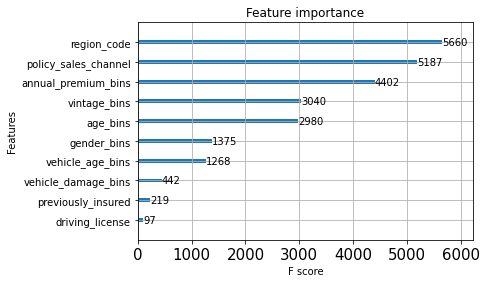

In [ ]:
plot_importance(model)

In [ ]:
tmp = val_data.copy()
y = np.array(tmp['response'])
tmp.drop(['response'], axis=1, inplace=True)

interim_preds = model.predict_proba(tmp)[:, 1]

In [ ]:
interim_preds = pd.DataFrame(interim_preds)
# # interim_preds.head()

In [ ]:
# threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# for t in threshold:
#   preds = interim_preds[0].apply(lambda x: 1 if x>t else 0)
#   print(t, roc_auc_score(y, preds))

In [ ]:
roc_auc_score(y, interim_preds)

0.8624808799050425

In [ ]:
orig_test = pd.read_csv('/content/test.csv')
preds = pd.DataFrame(model.predict_proba(test)[:, 1], columns=['Response'])
preds = pd.concat([orig_test['id'], preds], axis=1)
# preds['response'].value_counts()

In [ ]:
preds.to_csv('Baseline_xgb_09132020.csv', index=False)

### LightGBM

In [ ]:
train = unified[unified['train']==1]
test = unified[unified['train']==0]

columns = ['id', 'driving_license', 'previously_insured', 
           'annual_premium', 'age', 'region_code', 'policy_sales_channel',
           'vintage', 'gender_bins', 'vehicle_age_bins', 
           'vehicle_damage_bins', 'response', 'region_code_age_count',
           'region_code_age_mean', 'region_code_age_sd', 'region_code_age_min',
           'region_code_age_max',
           'region_code_annual_premium_mean', 'region_code_annual_premium_sd',
           'region_code_annual_premium_min', 'region_code_annual_premium_max',
           'region_code_vintage_mean',
           'region_code_vintage_sd', 'region_code_vintage_min',
           'region_code_vintage_max', 'policy_sales_channel_age_count',
           'policy_sales_channel_age_mean', 'policy_sales_channel_age_sd',
           'policy_sales_channel_age_min', 'policy_sales_channel_age_max',
           'policy_sales_channel_annual_premium_mean',
           'policy_sales_channel_annual_premium_sd',
           'policy_sales_channel_annual_premium_min',
           'policy_sales_channel_annual_premium_max',
           'policy_sales_channel_vintage_mean', 'policy_sales_channel_vintage_sd',
           'policy_sales_channel_vintage_min', 'policy_sales_channel_vintage_max'] 
           # 'region_code_me', 'policy_sales_channel_me', 'prem_age', 
           # 'prem_vin', 'vin_age'

train = train[columns]
test = test[columns]

# train = train[:100]

y = train['response']
train.drop(['response', 'id'], axis=1, inplace=True)
test.drop(['response', 'id'], axis=1, inplace=True)

In [ ]:
%%time
folds = 5
seed = [55] #, 231, 12, 958, 9
test_preds = pd.DataFrame()

for s in seed:
  val_data = pd.DataFrame()
  print(f'Running for seed {s}')
  skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=s)
  for i, (tr_idx, val_idx) in enumerate(skf.split(train, y)):
    print('*'*50)
    print(f'Fold number: {i+1}')

    X_tr, X_val, y_tr, y_val = train.iloc[tr_idx], train.iloc[val_idx], \
                              y.iloc[tr_idx], y.iloc[val_idx]  
    model = LGBMClassifier(
          boosting_type = 'gbdt'
        , max_depth = 8
        , learning_rate = 0.01
        , n_estimators = 5000
        , objective = 'binary'
        , subsample = 0.8
        , subsample_freq = 1
        , colsample_bytree = 0.6
        , silent=False
        , reg_lambda = 2
        )
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='auc',
              early_stopping_rounds=200, verbose=100)
    tmp = pd.concat([X_val, y_val], axis=1)

    val_data = pd.concat([val_data, tmp], axis=0)

  y2 = np.array(val_data['response'])
  val_data.drop(['response'], axis=1, inplace=True)
  interim_preds = model.predict_proba(val_data)[:, 1]

  print('#'*20)
  print(roc_auc_score(y2, interim_preds))

  tmp2 = pd.DataFrame(model.predict_proba(test)[:, 1])
  test_preds = pd.concat([test_preds, tmp2], axis=1)

Running for seed 55
**************************************************
Fold number: 1
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.855532	valid_0's binary_logloss: 0.292672
[200]	valid_0's auc: 0.856542	valid_0's binary_logloss: 0.273929
[300]	valid_0's auc: 0.857172	valid_0's binary_logloss: 0.267751
[400]	valid_0's auc: 0.857602	valid_0's binary_logloss: 0.26559
[500]	valid_0's auc: 0.857821	valid_0's binary_logloss: 0.264783
[600]	valid_0's auc: 0.857938	valid_0's binary_logloss: 0.264491
[700]	valid_0's auc: 0.85802	valid_0's binary_logloss: 0.264378
[800]	valid_0's auc: 0.858097	valid_0's binary_logloss: 0.264332
[900]	valid_0's auc: 0.858111	valid_0's binary_logloss: 0.264314
[1000]	valid_0's auc: 0.858162	valid_0's binary_logloss: 0.264285
[1100]	valid_0's auc: 0.858195	valid_0's binary_logloss: 0.264263
[1200]	valid_0's auc: 0.858149	valid_0's binary_logloss: 0.264281
[1300]	valid_0's auc: 0.85813	valid_0's binary_logloss: 0.264295
Early

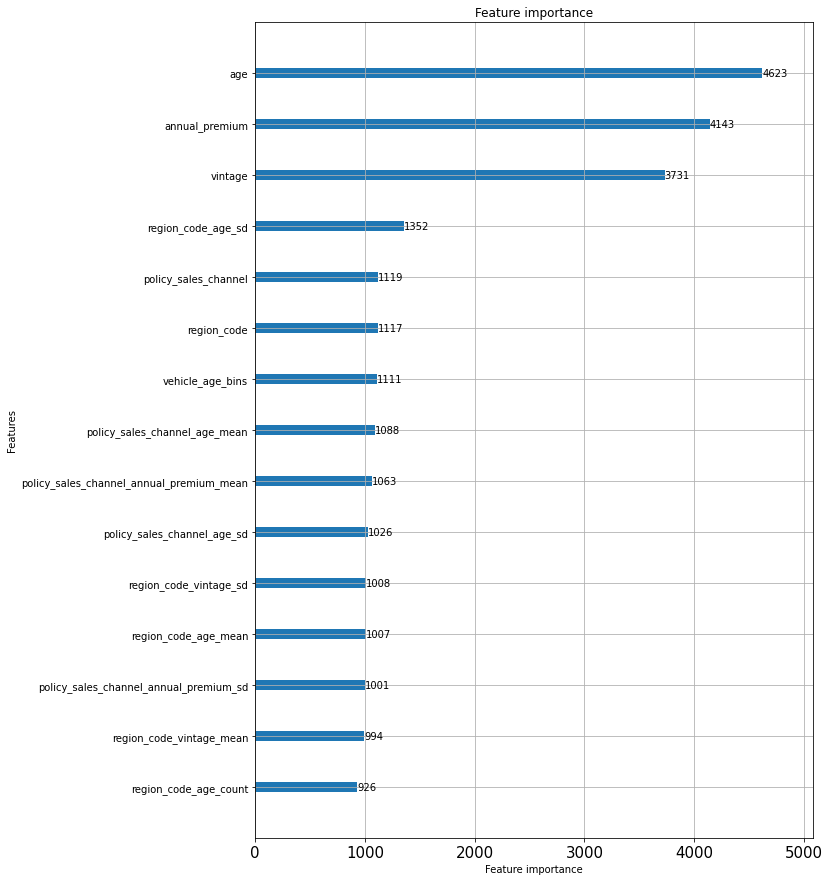

In [ ]:
plot_importance(model, max_num_features=15, figsize=(10,15))

In [ ]:
test_preds.head()

,0
0,0.000552
1,0.323157
2,0.305592
3,0.008349
4,0.000482


In [ ]:
tmp = test_preds.copy()
preds = pd.DataFrame(tmp.mean(axis=1), columns=['Response'])
preds.head()

,Response
0,0.000552
1,0.323157
2,0.305592
3,0.008349
4,0.000482


In [ ]:
orig_test = pd.read_csv('/content/test.csv')
# preds = pd.DataFrame(model.predict_proba(test)[:, 1], columns=['Response'])
preds = pd.concat([orig_test['id'], preds], axis=1)
preds.head()

,id,Response
0,381110,0.000552
1,381111,0.323157
2,381112,0.305592
3,381113,0.008349
4,381114,0.000482


In [ ]:
preds.to_csv('reg2_lgbm_09202020.csv', index=False)

## Logistic Regression

In [ ]:
train = unified[unified['train']==1]
test = unified[unified['train']==0]

columns = ['id', 'driving_license', 'region_code', 'previously_insured', 
           'policy_sales_channel', 'annual_premium', 'age',
           'vintage', 'gender_bins', 'vehicle_age_bins', 
           'vehicle_damage_bins', 'response', 'region_code_age_count',
           'region_code_age_mean', 'region_code_age_sd', 'region_code_age_min',
           'region_code_age_max',
           'region_code_annual_premium_mean', 'region_code_annual_premium_sd',
           'region_code_annual_premium_min', 'region_code_annual_premium_max',
           'region_code_vintage_mean',
           'region_code_vintage_sd', 'region_code_vintage_min',
           'region_code_vintage_max', 'policy_sales_channel_age_count',
           'policy_sales_channel_age_mean', 'policy_sales_channel_age_sd',
           'policy_sales_channel_age_min', 'policy_sales_channel_age_max',
           'policy_sales_channel_annual_premium_mean',
           'policy_sales_channel_annual_premium_sd',
           'policy_sales_channel_annual_premium_min',
           'policy_sales_channel_annual_premium_max',
           'policy_sales_channel_vintage_mean', 'policy_sales_channel_vintage_sd',
           'policy_sales_channel_vintage_min', 'policy_sales_channel_vintage_max']

train = train[columns]
test = test[columns]

# train = train[:10000]

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

y = train['response']

ss = StandardScaler()

scaled_train = train.copy()
scaled_train = pd.DataFrame(ss.fit_transform(scaled_train), columns=train.columns)

scaled_test = test.copy()
scaled_test = pd.DataFrame(ss.transform(scaled_test), columns=test.columns)

scaled_train.drop(['response', 'id'], axis=1, inplace=True)
scaled_test.drop(['response', 'id'], axis=1, inplace=True)

In [ ]:
scaled_train.head()

,driving_license,region_code,previously_insured,policy_sales_channel,annual_premium,age,vintage,gender_bins,vehicle_age_bins,vehicle_damage_bins,region_code_age_count,region_code_age_mean,region_code_age_sd,region_code_age_min,region_code_age_max,region_code_annual_premium_mean,region_code_annual_premium_sd,region_code_annual_premium_min,region_code_annual_premium_max,region_code_vintage_mean,region_code_vintage_sd,region_code_vintage_min,region_code_vintage_max,policy_sales_channel_age_count,policy_sales_channel_age_mean,policy_sales_channel_age_sd,policy_sales_channel_age_min,policy_sales_channel_age_max,policy_sales_channel_annual_premium_mean,policy_sales_channel_annual_premium_sd,policy_sales_channel_annual_premium_min,policy_sales_channel_annual_premium_max,policy_sales_channel_vintage_mean,policy_sales_channel_vintage_sd,policy_sales_channel_vintage_min,policy_sales_channel_vintage_max
0,0.046208,0.121784,-0.919638,-1.587234,0.574539,0.333777,0.748795,-0.921545,2.450281,0.990294,1.576784,1.303333,0.136388,-0.073015,0.947097,1.094725,0.984203,0.0,1.274343,-0.085931,0.076858,-0.044786,0.021918,-0.017912,1.025080,0.941899,-0.249282,0.966138,0.590115,0.996878,-0.009976,0.615319,0.041967,0.205131,-0.032343,0.041602
1,0.046208,-1.767879,-0.919638,-1.587234,0.172636,2.396751,0.342443,-0.921545,0.687976,-1.009801,-0.667229,-0.321106,0.439894,-0.073015,-0.718959,-0.824263,-0.143013,0.0,0.636191,0.611438,-2.058966,-0.044786,0.021918,-0.017912,1.025080,0.941899,-0.249282,0.966138,0.590115,0.996878,-0.009976,0.615319,0.041967,0.205131,-0.032343,0.041602
2,0.046208,0.121784,-0.919638,-1.587234,0.449053,0.527181,-1.521998,-0.921545,2.450281,0.990294,1.576784,1.303333,0.136388,-0.073015,0.947097,1.094725,0.984203,0.0,1.274343,-0.085931,0.076858,-0.044786,0.021918,-0.017912,1.025080,0.941899,-0.249282,0.966138,0.590115,0.996878,-0.009976,0.615319,0.041967,0.205131,-0.032343,0.041602
3,0.046208,-1.163187,1.087384,0.737321,-0.113018,-1.148985,0.581474,-0.921545,-1.074329,-1.009801,-0.667593,-0.803644,-0.332782,-0.073015,-0.718959,-0.392729,-0.313642,0.0,-0.638826,0.210062,0.172101,-0.044786,0.021918,1.120538,-1.091967,-1.154301,-0.249282,-0.715307,0.064785,-0.974877,-0.009976,0.260974,0.184346,-0.052806,-0.032343,0.041602
4,0.046208,1.104409,1.087384,0.737321,-0.178259,-0.633242,-1.378580,1.085134,-1.074329,-1.009801,-0.458548,-0.422510,0.029014,-0.073015,-0.163607,0.052883,0.026300,0.0,0.165904,0.595977,0.162613,-0.044786,0.021918,1.120538,-1.091967,-1.154301,-0.249282,-0.715307,0.064785,-0.974877,-0.009976,0.260974,0.184346,-0.052806,-0.032343,0.041602


In [ ]:
# train.isnull().sum()

In [ ]:
%%time

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=55)
val_data = pd.DataFrame()

for i, (tr_idx, val_idx) in enumerate(skf.split(scaled_train, y)):
  print('*'*50)
  print(f'Fold number: {i+1}')

  X_tr, X_val, y_tr, y_val = scaled_train.iloc[tr_idx], scaled_train.iloc[val_idx], \
                             y.iloc[tr_idx], y.iloc[val_idx]  

  model = LogisticRegression(C=3, max_iter=50000, solver='sag', n_jobs=-1)
  model.fit(X_tr, y_tr)

  tmp = pd.concat([X_val, y_val], axis=1)
  val_data = pd.concat([val_data, tmp], axis=0)

**************************************************
Fold number: 1
**************************************************
Fold number: 2
**************************************************
Fold number: 3
**************************************************
Fold number: 4
**************************************************
Fold number: 5
CPU times: user 4min 59s, sys: 66.2 ms, total: 4min 59s
Wall time: 4min 59s


In [ ]:
y2 = np.array(val_data['response'])
val_data.drop(['response'], axis=1, inplace=True)
interim_preds = model.predict_proba(val_data)[:, 1]

print(roc_auc_score(y2, interim_preds))

# tmp2 = pd.DataFrame(model.predict_proba(test)[:, 1])
# test_preds = pd.concat([test_preds, tmp2], axis=1)

0.8455662197857112


In [ ]:
lr_preds = pd.DataFrame(model.predict_proba(scaled_test)[:, 1], columns=['Response'])

In [ ]:
orig_test = pd.read_csv('/content/test.csv')
# preds = pd.DataFrame(model.predict_proba(test)[:, 1], columns=['Response'])
lr_preds = pd.concat([orig_test['id'], lr_preds], axis=1)
lr_preds.head()

,id,Response
0,381110,0.000481
1,381111,0.303347
2,381112,0.291215
3,381113,0.003129
4,381114,0.000479


In [ ]:
lr_preds.to_csv('lr_09192020.csv', index=False)

In [ ]:
preds.head()

,id,Response
0,381110,0.000575
1,381111,0.334836
2,381112,0.303175
3,381113,0.010626
4,381114,0.000479


In [ ]:
tmp = pd.concat([preds, lr_preds['Response']], axis=1)
tmp['new'] = (tmp.iloc[:, 1] + tmp.iloc[:, 2])/2
tmp = tmp.iloc[:,[0, 3]]
tmp.columns.values[-1] = 'Response'
tmp.head()

,id,Response
0,381110,0.000528
1,381111,0.319091
2,381112,0.297195
3,381113,0.006878
4,381114,0.000479


In [ ]:
tmp.to_csv('blend_lgbmlr_09192020.csv', index=False)

In [ ]:
# predict_proba vs predict
# Different result with roc_auc_score() and auc()

## CatBoost

In [ ]:
train = unified[unified['train']==1]
test = unified[unified['train']==0]

columns = ['id', 'driving_license', 'region_code', 'previously_insured', 
           'policy_sales_channel', 'annual_premium', 'age',
           'vintage', 'gender_bins', 'vehicle_age_bins', 
           'vehicle_damage_bins', 'response'
           ,'region_code_age_count',
           'region_code_age_mean', 'region_code_age_sd', 'region_code_age_min',
           'region_code_age_max',
           'region_code_annual_premium_mean', 'region_code_annual_premium_sd',
           'region_code_annual_premium_min', 'region_code_annual_premium_max',
           'region_code_vintage_mean',
           'region_code_vintage_sd', 'region_code_vintage_min',
           'region_code_vintage_max', 'policy_sales_channel_age_count',
           'policy_sales_channel_age_mean', 'policy_sales_channel_age_sd',
           'policy_sales_channel_age_min', 'policy_sales_channel_age_max',
           'policy_sales_channel_annual_premium_mean',
           'policy_sales_channel_annual_premium_sd',
           'policy_sales_channel_annual_premium_min',
           'policy_sales_channel_annual_premium_max',
           'policy_sales_channel_vintage_mean', 'policy_sales_channel_vintage_sd',
           'policy_sales_channel_vintage_min', 'policy_sales_channel_vintage_max']

cat_columns = ['gender_bins', 'driving_license', 'region_code',
               'previously_insured', 'vehicle_age_bins', 'vehicle_damage_bins',
               'policy_sales_channel']           

for c in cat_columns:
  train[c] = train[c].astype(int)
  test[c] = test[c].astype(int)
  
train = train[columns]
test = test[columns]

# train = train[:100]

y = train['response']
train.drop(['response', 'id'], axis=1, inplace=True) # 
test.drop(['response', 'id'], axis=1, inplace=True) # 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
%%time
folds = 5
seed = [55, 231, 12, 958, 9] 
test_preds = pd.DataFrame()

for s in seed:
  val_data = pd.DataFrame()
  print(f'Running for seed {s}')
  skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=s)
  for i, (tr_idx, val_idx) in enumerate(skf.split(train, y)):
    print('*'*50)
    print(f'Fold number: {i+1}')

    X_tr, X_val, y_tr, y_val = train.iloc[tr_idx], train.iloc[val_idx], \
                              y.iloc[tr_idx], y.iloc[val_idx]  
    model = CatBoostClassifier(
           early_stopping_rounds=200
         , verbose=100
         , learning_rate = 0.01
         , max_depth = 8
         , loss_function = 'Logloss'
         , random_seed = s
         , eval_metric = 'AUC'
        #  , subsample = 0.6
         , n_estimators = 5000
         , task_type = 'GPU'
        )
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], cat_features=cat_columns)
    tmp = pd.concat([X_val, y_val], axis=1)

    val_data = pd.concat([val_data, tmp], axis=0)

  y2 = np.array(val_data['response'])
  val_data.drop(['response'], axis=1, inplace=True)
  interim_preds = model.predict_proba(val_data)[:, 1]

  print('#'*20)
  print(roc_auc_score(y2, interim_preds))

  tmp2 = pd.DataFrame(model.predict_proba(test)[:, 1])
  test_preds = pd.concat([test_preds, tmp2], axis=1)

Running for seed 55
**************************************************
Fold number: 1
0:	learn: 0.7311091	test: 0.7335839	best: 0.7335839 (0)	total: 90.7ms	remaining: 7m 33s
100:	learn: 0.7377211	test: 0.7392737	best: 0.7392864 (97)	total: 5.65s	remaining: 4m 34s
200:	learn: 0.8463637	test: 0.8462277	best: 0.8462277 (200)	total: 11.7s	remaining: 4m 38s
300:	learn: 0.8523053	test: 0.8510224	best: 0.8510224 (300)	total: 17.6s	remaining: 4m 34s
400:	learn: 0.8550942	test: 0.8529706	best: 0.8529706 (400)	total: 23.4s	remaining: 4m 28s
500:	learn: 0.8570371	test: 0.8540331	best: 0.8540331 (500)	total: 29.2s	remaining: 4m 22s
600:	learn: 0.8582798	test: 0.8546723	best: 0.8546723 (600)	total: 34.8s	remaining: 4m 14s
700:	learn: 0.8592259	test: 0.8550849	best: 0.8550873 (699)	total: 40.5s	remaining: 4m 8s
800:	learn: 0.8599913	test: 0.8553676	best: 0.8553676 (800)	total: 46.1s	remaining: 4m 1s
900:	learn: 0.8606264	test: 0.8555413	best: 0.8555413 (900)	total: 51.7s	remaining: 3m 55s
1000:	lear

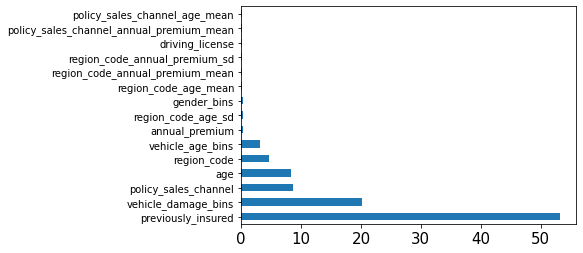

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X_tr.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [ ]:
test_preds.head()

,0,0,0,0,0
0,0.001096,0.000909,0.001140,0.001189,0.000965
1,0.376039,0.339057,0.357577,0.279820,0.345942
2,0.295327,0.284146,0.298092,0.298246,0.292878
3,0.006678,0.006077,0.007135,0.007299,0.006007
4,0.001065,0.000859,0.001113,0.001221,0.000982


In [ ]:
tmp = test_preds.copy()
preds = pd.DataFrame(tmp.mean(axis=1), columns=['Response'])
preds.head()

,Response
0,0.001060
1,0.339687
2,0.293738
3,0.006639
4,0.001048


In [ ]:
orig_test = pd.read_csv('/content/test.csv')
# preds = pd.DataFrame(model.predict_proba(test)[:, 1], columns=['Response'])
preds = pd.concat([orig_test['id'], preds], axis=1)
preds.head()

,id,Response
0,381110,0.001060
1,381111,0.339687
2,381112,0.293738
3,381113,0.006639
4,381114,0.001048


In [ ]:
preds.to_csv('params_catboost_09202020.csv', index=False)

## Neural Network

In [ ]:
def baselineNN(dims):
    model = Sequential()
    model.add(Dense(10, input_dim=dims, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [ ]:
def use_keras_nn_model(x, y, xx, yy, epochs):
    model = baselineNN(x.shape[1])
    model.fit(x, y, epochs=epochs)
    y_pred = model.predict(xx).reshape(xx.shape[0],)
    return y_pred, model

In [ ]:
train = unified[unified['train']==1]
test = unified[unified['train']==0]

columns = ['id', 'driving_license', 'region_code', 'previously_insured', 
           'policy_sales_channel', 'annual_premium', 'age',
           'vintage', 'gender_bins', 'vehicle_age_bins', 
           'vehicle_damage_bins', 'response', 'region_code_age_count',
           'region_code_age_mean', 'region_code_age_sd', 'region_code_age_min',
           'region_code_age_max',
           'region_code_annual_premium_mean', 'region_code_annual_premium_sd',
           'region_code_annual_premium_min', 'region_code_annual_premium_max',
           'region_code_vintage_mean',
           'region_code_vintage_sd', 'region_code_vintage_min',
           'region_code_vintage_max', 'policy_sales_channel_age_count',
           'policy_sales_channel_age_mean', 'policy_sales_channel_age_sd',
           'policy_sales_channel_age_min', 'policy_sales_channel_age_max',
           'policy_sales_channel_annual_premium_mean',
           'policy_sales_channel_annual_premium_sd',
           'policy_sales_channel_annual_premium_min',
           'policy_sales_channel_annual_premium_max',
           'policy_sales_channel_vintage_mean', 'policy_sales_channel_vintage_sd',
           'policy_sales_channel_vintage_min', 'policy_sales_channel_vintage_max']

train = train[columns]
test = test[columns]

# train = train[:10000]

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

y = train['response']

ss = StandardScaler()

scaled_train = train.copy()
scaled_train = pd.DataFrame(ss.fit_transform(scaled_train), columns=train.columns)

scaled_test = test.copy()
scaled_test = pd.DataFrame(ss.transform(scaled_test), columns=test.columns)

scaled_train.drop(['response', 'id'], axis=1, inplace=True)
scaled_test.drop(['response', 'id'], axis=1, inplace=True)

In [ ]:
%%time
folds = 2
seed = [55] #, 231, 12, 958, 9
test_preds = pd.DataFrame()

X_tr, X_val, y_tr, y_val = train_test_split(scaled_train, y, test_size=0.2, 
                                            random_state=123)
y_pred_nn, model_nn = use_keras_nn_model(X_tr, y_tr, X_val, y_val, 100)

Epoch 1/100
9528/9528 [==============================] - 10s 1ms/step - loss: 0.2843 - accuracy: 0.8738
Epoch 2/100
9528/9528 [==============================] - 10s 1ms/step - loss: 0.2713 - accuracy: 0.8774
Epoch 3/100
9528/9528 [==============================] - 10s 1ms/step - loss: 0.2704 - accuracy: 0.8773
Epoch 4/100
9528/9528 [==============================] - 10s 1ms/step - loss: 0.2699 - accuracy: 0.8773
Epoch 5/100
9528/9528 [==============================] - 10s 1ms/step - loss: 0.2695 - accuracy: 0.8773
Epoch 6/100
9528/9528 [==============================] - 10s 1ms/step - loss: 0.2695 - accuracy: 0.8773
Epoch 7/100
9528/9528 [==============================] - 10s 1ms/step - loss: 0.2693 - accuracy: 0.8773
Epoch 8/100
9528/9528 [==============================] - 10s 1ms/step - loss: 0.2695 - accuracy: 0.8773
Epoch 9/100
9528/9528 [==============================] - 10s 1ms/step - loss: 0.2691 - accuracy: 0.8773
Epoch 10/100
9528/9528 [==============================] - 11s 1m

In [ ]:
preds = pd.DataFrame(model_nn.predict_proba(scaled_test), columns=['Response'])
preds.head()

Instructions for updating:
Please use `model.predict()` instead.


,Response
0,0.000143
1,0.313696
2,0.284198
3,0.002229
4,0.000183


In [ ]:
orig_test = pd.read_csv('/content/test.csv')
# preds = pd.DataFrame(model.predict_proba(test)[:, 1], columns=['Response'])
preds = pd.concat([orig_test['id'], preds], axis=1)
preds.head()

,id,Response
0,381110,0.000143
1,381111,0.313696
2,381112,0.284198
3,381113,0.002229
4,381114,0.000183


In [ ]:
preds.to_csv('nn_09192020.csv', index=False)

## LightGBM Hyperparameter Optimization

In [ ]:
train = unified[unified['train']==1]
test = unified[unified['train']==0]

columns = ['id', 'driving_license', 'region_code', 'previously_insured', 
           'policy_sales_channel', 'annual_premium', 'age',
           'vintage', 'gender_bins', 'vehicle_age_bins', 
           'vehicle_damage_bins', 'response', 'region_code_age_count',
           'region_code_age_mean', 'region_code_age_sd', 'region_code_age_min',
           'region_code_age_max',
           'region_code_annual_premium_mean', 'region_code_annual_premium_sd',
           'region_code_annual_premium_min', 'region_code_annual_premium_max',
           'region_code_vintage_mean',
           'region_code_vintage_sd', 'region_code_vintage_min',
           'region_code_vintage_max', 'policy_sales_channel_age_count',
           'policy_sales_channel_age_mean', 'policy_sales_channel_age_sd',
           'policy_sales_channel_age_min', 'policy_sales_channel_age_max',
           'policy_sales_channel_annual_premium_mean',
           'policy_sales_channel_annual_premium_sd',
           'policy_sales_channel_annual_premium_min',
           'policy_sales_channel_annual_premium_max',
           'policy_sales_channel_vintage_mean', 'policy_sales_channel_vintage_sd',
           'policy_sales_channel_vintage_min', 'policy_sales_channel_vintage_max']

train = train[columns]
test = test[columns]

# train = train[:100]

y = train['response']
train.drop(['response', 'id'], axis=1, inplace=True)
test.drop(['response', 'id'], axis=1, inplace=True)

In [ ]:
%%time
param_grid_lgbm = {
      'max_depth' : [5,6,7,8]
    , 'learning_rate' : [0.01, 0.1, 0.2]
    , 'subsample' : [0.6, 0.7, 0.8]
    , 'colsample_bytree' : [0.6, 0.7, 0.8]    
}

model_lgbm = LGBMClassifier(     
      boosting_type = 'gbdt'
    , objective = 'binary'
    , n_estimators = 1000
)

hp_lgbm = GridSearchCV(model_lgbm, param_grid=param_grid_lgbm, n_jobs=-1, 
                       verbose=1, cv=2)
hp_lgbm.fit(train, y)

print(f'Best params are: {hp_lgbm.best_params_}')
print(f'Best score is: {hp_lgbm.best_score_}')

Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 84.5min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 93.4min finished


Best params are: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'subsample': 0.6}
Best score is: 0.8775547152135476
CPU times: user 1min 41s, sys: 703 ms, total: 1min 42s
Wall time: 1h 34min 14s
